In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
PRE_NAME = "onemin_ohlc_"
BEGIN_TIME = "09:00:00"
END_TIME = "11:00:00"
NUM_CLUSTER = 50
TIME_STEP = 5
def load_data(date_begin='20180612', date_end = '20200301', split_date_begin = '20200302', split_date_end = '20200915', train = True):
    X = []
    Y = []

    
    for sid in tqdm(os.listdir(os.path.join('dataset'))):
        for file in os.listdir(os.path.join('dataset', sid)):
            curday = file[12:20]
            if (train == True and curday <= date_end and curday >= date_begin) or (train == False and curday >= split_date_begin and curday <= split_date_end):
                df = pd.read_csv(os.path.join('dataset', sid, file))
                df = df
                mask = (df.loc[:, "time"] >= BEGIN_TIME) & (df.loc[:, "time"] <= END_TIME)
                front_df = df[mask].loc[:, "return"]
                front_df = front_df.take(np.arange(0, len(front_df), TIME_STEP))
                end_df = df[~mask].loc[:, "return"]
                if len(front_df) == (121 // TIME_STEP +1):
                    X.append(np.array(front_df))
                    Y.append(np.array(end_df))
    return np.array(X), np.array(Y)

def dtw_d(X, Y):
    manhattan_distance = lambda x, y: np.abs(x - y)
    d, cost_matrix, acc_cost_matrix, path = dtw(X, Y, dist=manhattan_distance)
    return d

def dtw_affinity(X):
    return pairwise_distances(X, metric=dtw_d)

def fastdtw_d(X, Y):
    manhattan_distance = lambda x, y: np.abs(x - y)
    return fastdtw(X, Y, dist=manhattan_distance)[0]

def fastdtw_affinity(X):
    return pairwise_distances(X, metric=fastdtw_d)


X, Y = load_data()

100%|██████████| 13/13 [00:14<00:00,  1.11s/it]


In [2]:
X_test, Y_test = load_data(train=False)

100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


In [3]:
print(X.shape)

(2492, 25)


In [4]:
print(X_test.shape)

(771, 25)


In [ ]:
t1 = time.time()
fastdtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)
t1 = time.time()
dtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)

In [5]:
t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = fastdtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

4328.332884311676


In [ ]:
t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = dtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

In [ ]:
t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

In [6]:
X_label

array([30, 15, 30, ...,  8,  9,  1], dtype=int64)

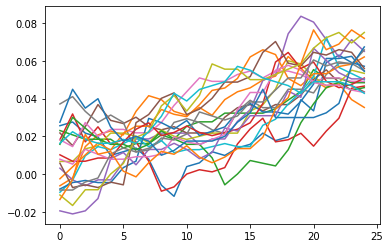

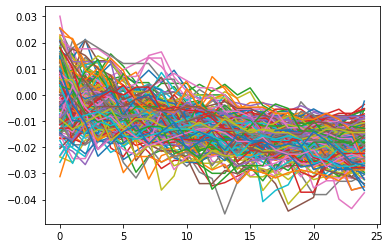

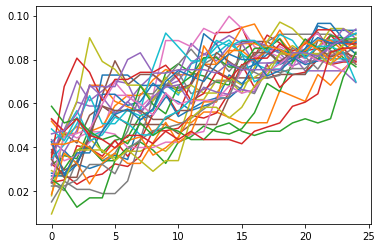

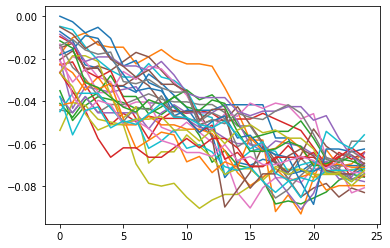

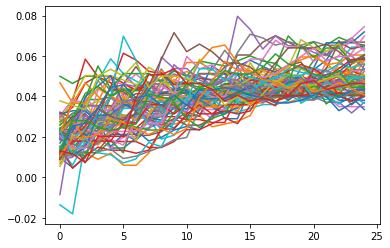

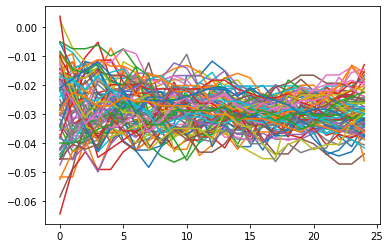

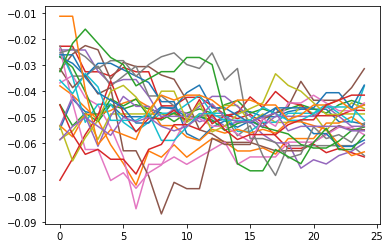

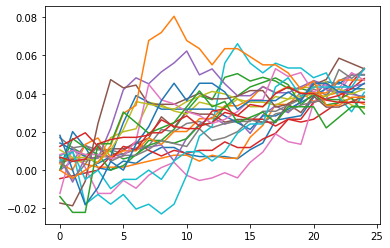

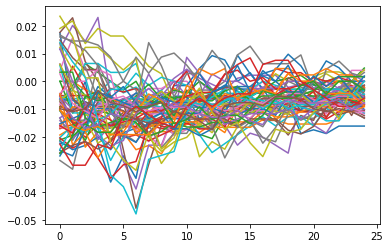

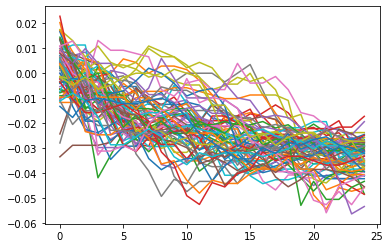

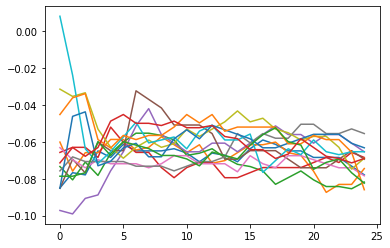

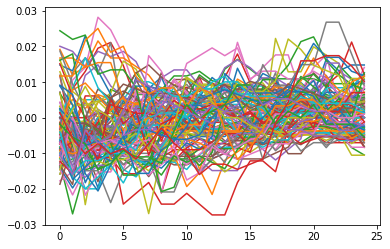

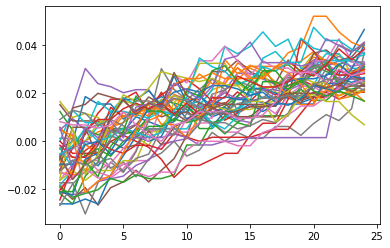

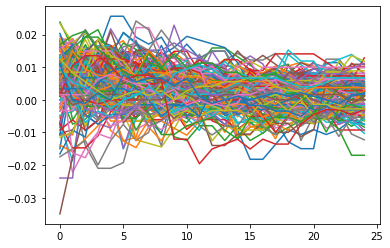

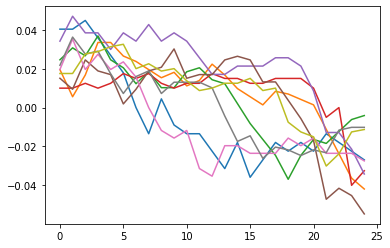

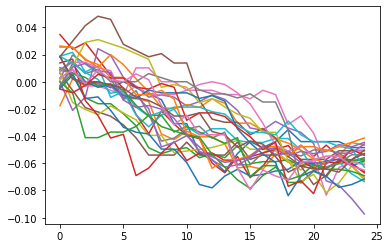

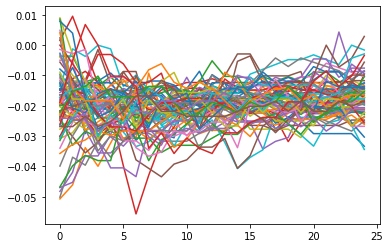

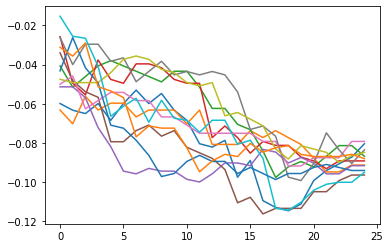

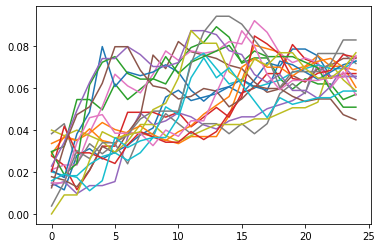

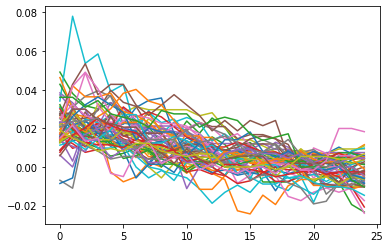

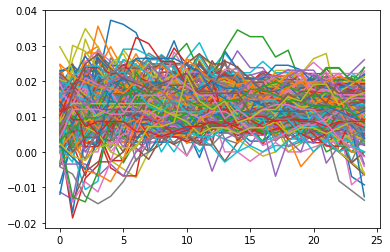

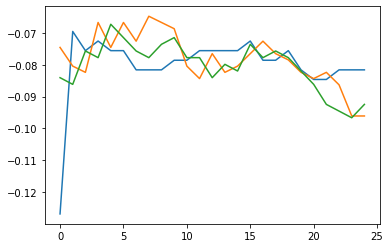

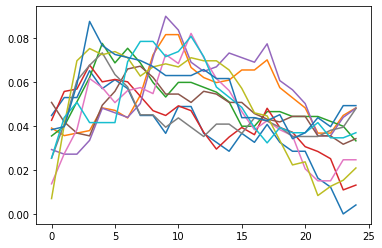

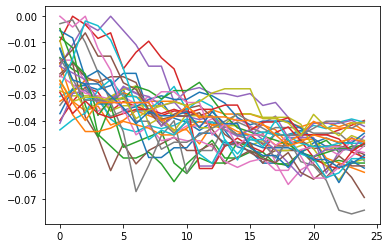

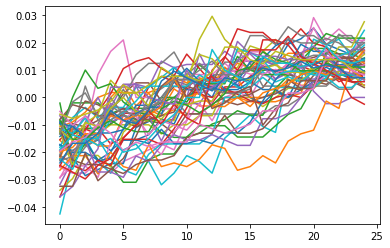

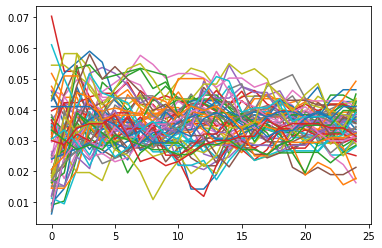

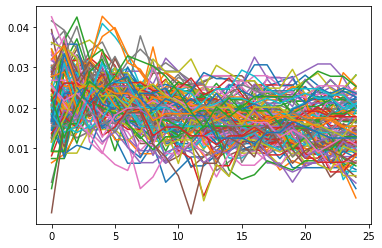

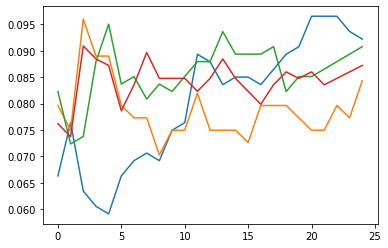

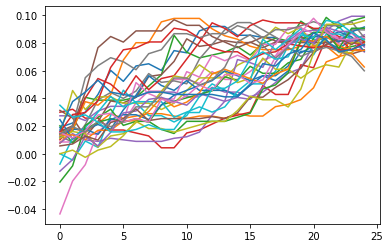

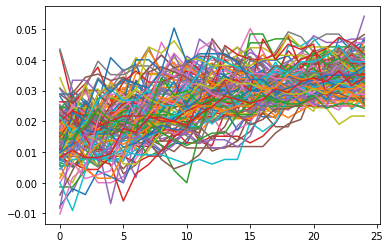

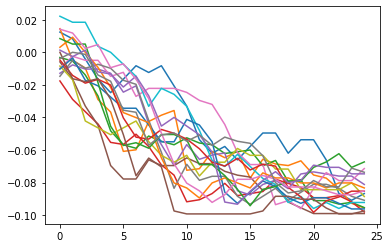

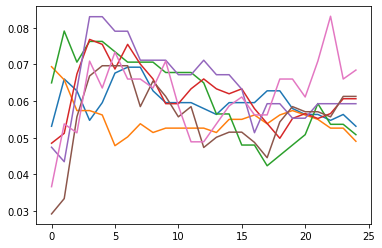

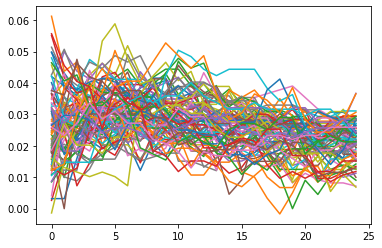

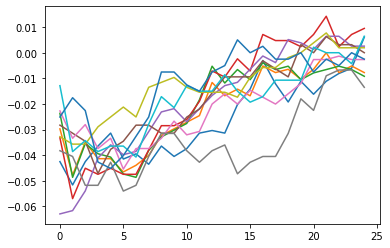

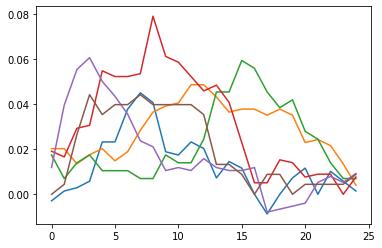

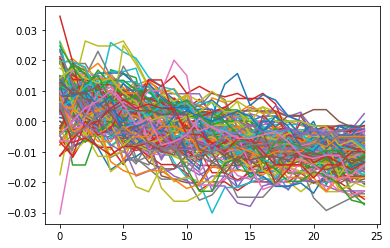

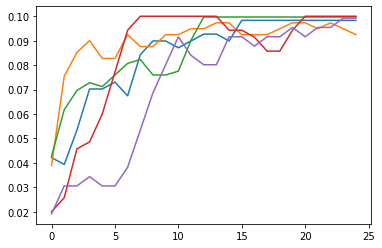

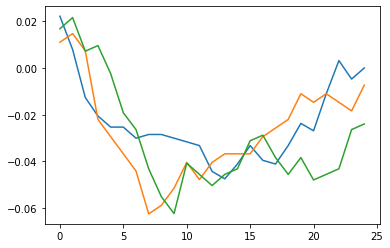

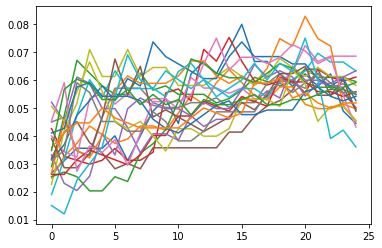

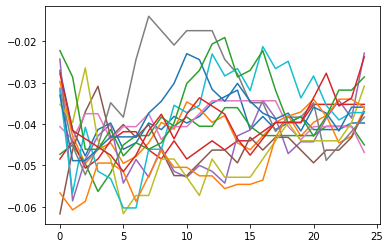

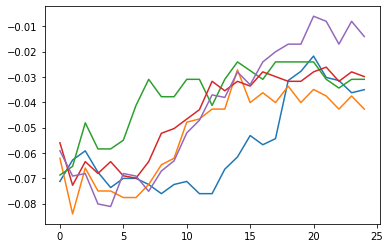

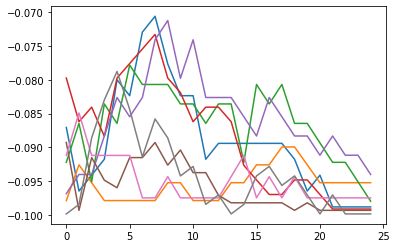

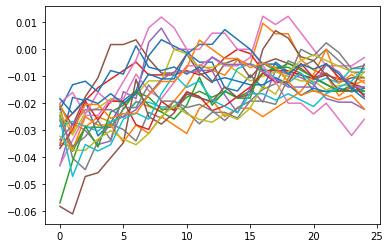

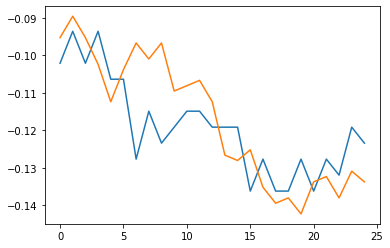

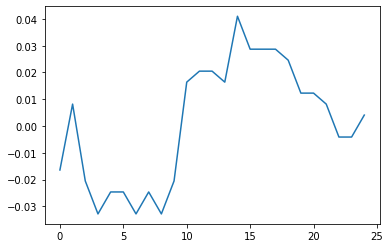

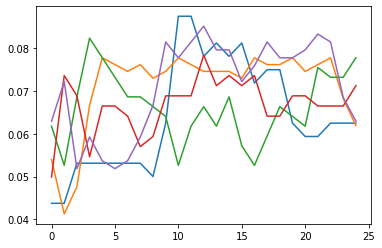

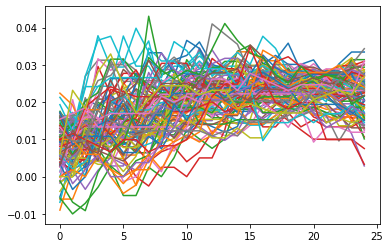

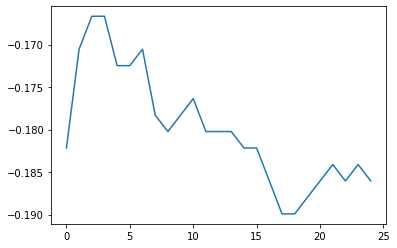

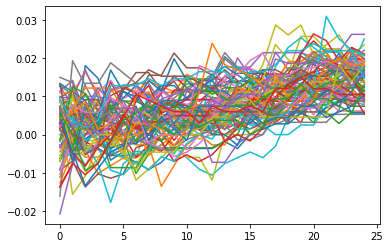

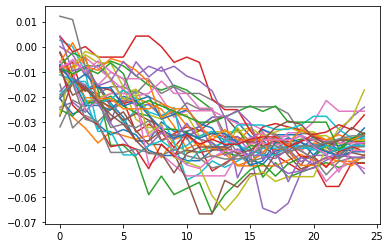

In [7]:
for n in range(NUM_CLUSTER):
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == n:
            plt.plot(X[i])
    plt.show()

In [8]:
def make_long_simple(y, cost):
    return y.max() - y[0] - cost
def make_short_simple(y, cost):
    return y[0] - y.min() - cost
def make_long_max_lost(y, cost):
    return y.min() - y[0] - cost
def make_short_max_lost(y, cost):
    return y[0] - y.max() - cost
def make_long(y, cost, exp_profit):
    if np.sum(y-y[0]-cost >= exp_profit):
        return exp_profit
    else:
        return y[-1] - y[0] - cost

def make_short(y, cost, exp_profit):
    if np.sum(y[0]-y-cost >= exp_profit):
        return exp_profit
    else:
        return -y[-1] + y[0] - cost

In [9]:
X_label

array([30, 15, 30, ...,  8,  9,  1], dtype=int64)

In [10]:
def make_table(X, X_label):
    X_mean = np.zeros((len(X_label), len(X[0])))
    for i in range(NUM_CLUSTER):
        X_mean[X_label[i]] = X[X_label==i].mean(axis=0)
    return X_mean
X_table = make_table(X, X_label)
pickle.dump(X_table, open("X_tabel.pk", "wb"))

In [11]:
len(X)

2492

In [12]:
Y.shape

(2492,)

In [13]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long_simple(Y[i], 0.002)
    profit_short_array[X_label[i]] += make_short_simple(Y[i], 0.002)
    lost_long_array[X_label[i]] += make_long_max_lost(Y[i], 0.002)
    lost_short_array[X_label[i]] += make_short_max_lost(Y[i], 0.002)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print(profit_long_array)
print(profit_short_array)
print(lost_long_array)
print(lost_short_array)
print(num_long_array)
print(num_short_array)

[ 0.35227033  1.11581518  0.31739987  0.12756557  1.26856223  0.61049503
  0.36320278  0.34512032  0.7243872   0.46339359  0.22083268  0.93896803
  0.55296253  1.37184368  0.31457618  0.42427506  0.81376912  0.05200785
  0.27509951  0.63173629  2.25056597  0.10170097  0.11774147  0.2114684
  0.51239667  0.83557457  0.65116665  0.01928623  0.39141981  1.4729278
  0.22652355  0.08897888  0.96344233  0.32120019  0.11128787  0.87494354
 -0.00513382  0.08204959  0.38599702  0.15599618  0.14712475  0.00390051
  0.22309848  0.0172887   0.04718033  0.03054218  0.76317213  0.00381395
  0.97235133  0.29739196]
[ 3.47101790e-01  2.36211200e+00  3.99868984e-01  5.65214998e-01
  7.77286286e-01  1.09146008e+00  3.43279196e-01  4.53757037e-01
  4.82302218e-01  1.04384789e+00  2.02956962e-01  1.07103310e+00
  5.21679855e-01  1.68863667e+00  1.27234256e-01  5.96496424e-01
  7.86027311e-01  1.46257236e-01  3.15190685e-01  8.36255562e-01
  1.82181853e+00  2.26330532e-03  2.69882243e-01  3.74207369e-01
  

In [ ]:
pickle.dump(ac, open("ac_model2.pc", 'wb'))

In [ ]:
#ac = pickle.load(open("ac_model2.pc", 'rb'))

In [14]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long_simple(Y[i], 0.002)
    profit_short_array[X_label[i]] += make_short_simple(Y[i], 0.002)
    lost_long_array[X_label[i]] += make_long_max_lost(Y[i], 0.002)
    lost_short_array[X_label[i]] += make_short_max_lost(Y[i], 0.002)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print('best avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
print('best avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
print('worst avg long return', sorted(lost_long_array/num_long_array)[::-1][:10])
print('worst avg short return', sorted(lost_short_array/num_short_array)[::-1][:10])
print(num_long_array)
print(num_short_array)

best avg long return [0.04718032786885245, 0.03495290895517687, 0.03390032186086921, 0.02942495074886129, 0.029200016851148935, 0.027349863370658627, 0.01854797876234145, 0.017142732811048247, 0.01678247895586494, 0.016012287926884448]
best avg short return [0.031089692481695658, 0.02453474935327986, 0.022092460150581816, 0.02202210483781142, 0.018906543212978726, 0.01884049994782534, 0.017682748653773426, 0.017209241378535096, 0.017125153591500332, 0.0161457098417711]
worst avg long return [-0.002, -0.002686813186813186, -0.0035446645811609487, -0.004754435107376284, -0.005875968992248097, -0.011307609368366731, -0.011316540278885909, -0.011945219575678718, -0.012003017400371975, -0.01203244252959628]
worst avg short return [-0.0029732360097323727, -0.004487564128026673, -0.007813953488372076, -0.008252185617759878, -0.008333987434496292, -0.008821556743077507, -0.009294037799467327, -0.009537617315037198, -0.009841964319138592, -0.010108435339556623]
[ 22 191  35  30  74  83  25  24 

In [15]:
def find_cluster(X, X_table):
    prev_min = dtw_d(X, X_table[0])
    prev_min_arg = 0
    for i in range(1, NUM_CLUSTER):
        cur_min = fastdtw_d(X, X_table[i])
        if prev_min >= cur_min:
            prev_min = cur_min
            prev_min_arg = i
    return prev_min_arg

In [ ]:
def find_cluster_L2(X, X_table):
    prev_min = dtw_d(X, X_table[0])
    prev_min_arg = 0
    for i in range(1, NUM_CLUSTER):
        cur_min = np.sum((X - X_table[i])**2)
        if prev_min >= cur_min:
            prev_min = cur_min
            prev_min_arg = i
    return prev_min_arg

In [ ]:
find_cluster_L2(X_test[0], X_table)

In [22]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long(Y[i], 0.002, 0.025)
    profit_short_array[X_label[i]] += make_short(Y[i], 0.002, 0.025)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print('avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
print('avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
print(num_long_array)
print(num_short_array)
best_long_cluster = np.argsort(profit_long_array/num_long_array)[::-1]
best_short_cluster = np.argsort(profit_short_array/num_long_array)[::-1]

avg long return [0.025, 0.012812210702413174, 0.006243007927247664, 0.0042455648926237165, 0.003869198312236262, 0.0028466406029321544, 0.002537129045220601, 0.0020900514825828846, 0.0020083182586268446, 0.0019875259847834665]
avg short return [0.011009132540602406, 0.007945219575678718, 0.007028502596471799, 0.00683230540118412, 0.006292738773332291, 0.006038550623765866, 0.00541156894079194, 0.005183249744579432, 0.005087122022205839, 0.003733810619891816]
[ 22 191  35  30  74  83  25  24  66  71  14 115  48 211   9  27  76  12
  20  59 249   3  11  32  51  64 123   4  31 114  18   7  87  11   6 158
   5   3  23  14   5   8  22   2   1   5  99   1  85  38]
[ 22 191  35  30  74  83  25  24  66  71  14 115  48 211   9  27  76  12
  20  59 249   3  11  32  51  64 123   4  31 114  18   7  87  11   6 158
   5   3  23  14   5   8  22   2   1   5  99   1  85  38]


In [33]:
best_long_cluster

array([44, 33, 14, 21, 37,  2, 38,  4,  8, 12, 29, 24, 18, 48, 40,  7, 34,
       28, 36, 20, 16, 41,  0, 11, 46, 25, 31,  6, 13, 47, 42, 30,  5, 35,
       45, 23,  1, 10, 32, 15, 49,  9, 19, 26, 17, 39, 43, 22,  3, 27],
      dtype=int64)

In [24]:
best_short_cluster

array([ 3, 43, 17, 45, 23,  9, 19, 22, 26,  1, 49, 32, 35, 47, 15,  5, 39,
       13, 31, 46, 25, 34, 10, 41, 27, 20,  7, 36, 42, 11, 30,  0, 16, 28,
       18, 48, 12,  6, 24,  8,  4,  2, 29, 38, 37, 14, 40, 33, 21, 44],
      dtype=int64)

In [35]:
def evaluate(X_test, Y_test, X_table):
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    lost_long_array = np.zeros(NUM_CLUSTER)
    lost_short_array = np.zeros(NUM_CLUSTER)
    num_long_array = np.zeros(NUM_CLUSTER).astype("int")
    num_short_array = np.zeros(NUM_CLUSTER).astype("int")
    X_label = np.zeros(NUM_CLUSTER).astype("int")
    for i in range(len(X_test)):
        X_label = find_cluster(X_test[i], X_table)
        profit_long_array[X_label] += make_long(Y_test[i], 0.002, 0.025)
        profit_short_array[X_label] += make_short(Y_test[i], 0.002, 0.025)
        num_long_array[X_label] += 1
        num_short_array[X_label] += 1
        
        
    print('avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
    print('avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
    print(num_long_array)
    print(num_short_array)
    return profit_long_array, profit_short_array, num_long_array 

        

In [36]:
profit_long_array, profit_short_array, num_long_array  = evaluate(X_test, Y_test, X_table)

avg long return [nan, nan, 0.014752547807168215, nan, nan, 0.014304347826086953, -0.004441226837387036, nan, nan, nan]
avg short return [nan, nan, nan, nan, 0.025, 0.003615387539438013, -0.00011075939213416665, nan, nan, nan]
[  5  54   0   1  21  13  32  17  36   0   0  67   0  15   8 103   7  62
  85   7  12   0  20   0   0  13   0   0   0  32  30   0  40  26   0  11
   0   0   0   0   0   0  13   1   0   0   2   0   0  38]
[  5  54   0   1  21  13  32  17  36   0   0  67   0  15   8 103   7  62
  85   7  12   0  20   0   0  13   0   0   0  32  30   0  40  26   0  11
   0   0   0   0   0   0  13   1   0   0   2   0   0  38]


C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [37]:
for i in range(len(best_long_cluster)):
    print(i, best_long_cluster[i], profit_long_array[best_long_cluster[i]], num_long_array[best_long_cluster[i]], profit_long_array[best_long_cluster[i]]/num_long_array[best_long_cluster[i]])

0 44 0.0 0 nan
1 33 -0.25855356596017454 26 -0.009944367921545174
2 14 -0.026628473285448526 8 -0.0033285591606810657
3 21 0.0 0 nan
4 37 0.0 0 nan
5 2 0.0 0 nan
6 38 0.0 0 nan
7 4 -0.10437104085998013 21 -0.004970049564760958
8 8 0.05992161388415085 36 0.0016644892745597457
9 12 0.0 0 nan
10 29 -0.10343440091491973 32 -0.0032323250285912417
11 24 0.0 0 nan
12 18 -0.969720083285982 85 -0.011408471568070377
13 48 0.0 0 nan
14 40 0.0 0 nan
15 7 0.0073074588421698575 17 0.00042985052012763867
16 34 0.0 0 nan
17 28 0.0 0 nan
18 36 0.0 0 nan
19 20 0.031781968606783194 12 0.0026484973838985996
20 16 -0.0340393132620051 7 -0.0048627590374293
21 41 0.0 0 nan
22 0 -0.02468617472004621 5 -0.004937234944009242
23 11 0.04349273931610209 67 0.0006491453629268969
24 46 0.02950509561433643 2 0.014752547807168215
25 25 -0.058293298306106314 13 -0.004484099869700485
26 31 0.0 0 nan
27 6 -0.017094175611737948 32 -0.0005341929878668109
28 13 -0.03467361914583637 15 -0.0023115746097224243
29 47 0.0 0 nan


C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [39]:
profit_short_array

array([ 0.00468617,  0.07463152,  0.        ,  0.025     ,  0.09511282,
       -0.14203699, -0.10143106,  0.00256086, -0.27202365,  0.        ,
        0.        , -0.31567326,  0.        , -0.00552421,  0.01478324,
        0.1812158 ,  0.03747886,  0.05811824,  0.44092993,  0.02526055,
       -0.07978197,  0.        ,  0.05607244,  0.        ,  0.        ,
       -0.0579382 ,  0.        ,  0.        ,  0.        , -0.0363853 ,
        0.00448498,  0.        ,  0.28037942,  0.11674479,  0.        ,
       -0.13199834,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.04700004,  0.025     ,  0.        ,
        0.        , -0.0375051 ,  0.        ,  0.        , -0.00420886])

In [38]:
for i in range(len(best_short_cluster)):
    print(i, best_short_cluster[i], profit_short_array[best_short_cluster[i]], num_short_array[best_long_cluster[i]], profit_short_array[best_short_cluster[i]] / num_short_array[best_long_cluster[i]])

0 3 0.025 1 0.025
1 43 0.025 11 0.002272727272727273
2 17 0.05811824373188207 9 0.0064575826368757855
3 45 0.0 3 0.0
4 23 0.0 3 0.0
5 9 0.0 35 0.0
6 19 0.025260554869564897 23 0.0010982849943289086
7 22 0.056072442106210464 74 0.0007577357041379792
8 26 0.0 66 0.0
9 1 0.0746315213230277 48 0.0015548233608964103
10 49 -0.004208856901098333 114 -3.691979737805555e-05
11 32 0.28037941680533995 51 0.005497635623634116
12 35 -0.1319983403006454 20 -0.006599917015032269
13 47 0.0 85 0.0
14 15 0.18121579916128389 5 0.036243159832256774
15 5 -0.1420369888927345 24 -0.005918207870530604
16 39 0.0 6 0.0
17 13 -0.005524213884924066 31 -0.00017820044790077633
18 31 0.0 5 0.0
19 46 -0.03750509561433643 249 -0.00015062287395315835
20 25 -0.0579382033137171 76 -0.0007623447804436461
21 34 0.0 8 0.0
22 10 0.0 22 0.0
23 41 0.0 115 0.0
24 27 0.0 99 0.0
25 20 -0.0797819686067832 64 -0.0012465932594809875
26 7 0.0025608579482264415 7 0.0003658368497466345
27 36 0.0 25 0.0
28 42 0.04700003801269417 211 0.0

In [ ]:
best_long_cluster = np.argsort(profit_long_array/num_long_array)[::-1]
for n in range(10):
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == n:
            plt.plot(X[i])
    plt.show()